In [1]:
# import all of the needed
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
import seaborn as sns
from scipy import linalg as LA

np.random.seed(0)
np.set_printoptions(precision = 3,suppress =True)
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# import data
mnist = input_data.read_data_sets('../../Dataset/MNIST/',one_hot=True)
train_data, train_label, test_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

# Show some details and vis some of them
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_label.shape)
print(train_label.min(),train_label.max())
print(test_data.shape)
print(test_data.min(),test_data.max())
print(test_label.shape)
print(test_label.min(),test_label.max())
print('-----------------------')

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz
(55000, 784)
0.0 1.0
(55000, 10)
0.0 1.0
(10000, 784)
0.0 1.0
(10000, 10)
0.0 1.0
-----------------------


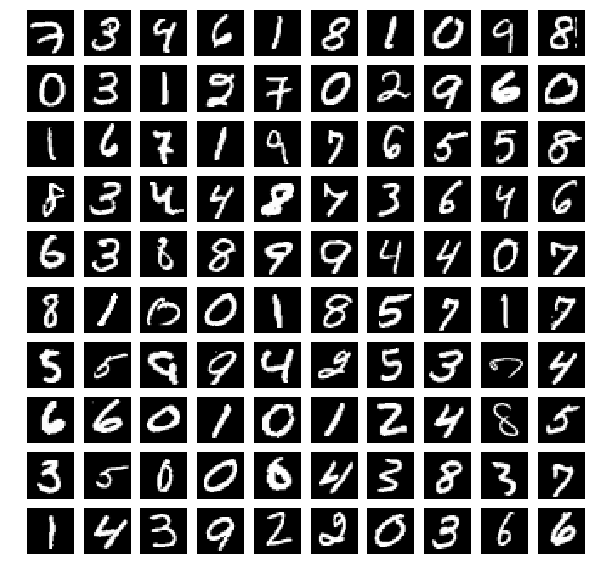

In [3]:
# view the data
def view_images(data,row=10,col=10,color=False):
    fig=plt.figure(figsize=(10, 10))
    columns = col;    rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if color:plt.imshow(data[i-1])
        else:    plt.imshow(data[i-1],cmap='gray')
        plt.grid(False)
        plt.axis('off')
    plt.show()
view_images(train_data.reshape((55000,28,28)))

In [87]:
# Define layers and the activation functions
def tf_elu(x):    return tf.nn.elu(x)
def d_tf_elu(x):  return tf.cast(tf.greater_equal(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x):   return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x):   return x
def d_tf_iden(x): return x

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x):    return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x):   return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class CNN_stacked_denoising():

    def __init__(self,k,inc,out,stddev=0.05,which_reg=0,act=tf_elu,d_act=d_tf_elu):
        self.w        = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA
    
    def feedforward_inverse(self,input,stride=1,padding='VALID'):
        self.input_inv = input
        self.layer_inv = tf.nn.conv2d_transpose(self.input_inv,self.w,strides=[1,stride,stride,1],output_shape=tf.shape(self.input),padding=padding)
        self.layerA_inv= self.act(self.layer_inv)
        return self.layerA_inv

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),
        filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.which_reg == 0:   grad = grad
        if self.which_reg == 0.5: grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
        if self.which_reg == 1:   grad = grad + lamda * tf.sign(self.w)
        if self.which_reg == 1.5: grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
        if self.which_reg == 2:   grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
        if self.which_reg == 2.5: grad = grad + lamda * 2.0 * self.w
        if self.which_reg == 3:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
        if self.which_reg == 4:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [188]:
# hyper parameters as well as the stuffs
num_epoch = 1; learning_rate  = 0.0008 ; batch_size = 100
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = CNN_stacked_denoising(6,1,8)
l2 = CNN_stacked_denoising(8,8,16)
l3 = CNN_stacked_denoising(10,16,32)

In [189]:
# create the place holder and go 
x            = tf.placeholder(shape=[batch_size,28,28,1],dtype=tf.float32)

layer1_input = tf.placeholder(shape=[batch_size,28,28,1],dtype=tf.float32)
layer1      = l1.feedforward(layer1_input,padding="VALID")
layer1_inv  = l1.feedforward_inverse(layer1)
layer1_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=layer1_inv))
layer1_train= tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(layer1_cost)
# layer1_same = l1.feedforward(layer1_input,pa dding="SAME")

layer2_input= tf_sigmoid(tf.placeholder(shape=[batch_size,19,19,8],dtype=tf.float32))
layer2      = l2.feedforward(layer2_input,padding="VALID")
layer2_inv  = l2.feedforward_inverse(layer2)
layer2_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=layer2_input,logits=layer2_inv))
layer2_train= tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(layer2_cost)
# layer2_same = l2.feedforward(layer1_same,padding="SAME")

layer3_input= tf_sigmoid(tf.placeholder(shape=[batch_size,12,12,16],dtype=tf.float32))
layer3      = l3.feedforward(layer3_input,padding="VALID")
layer3_inv  = l3.feedforward_inverse(layer3)
layer3_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=layer3_input,logits=layer3_inv))
layer3_train= tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(layer3_cost)

In [ ]:
# start the tf session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# start training the first layer
for iter in range(num_epoch):
    for current_data_index in range(0,len(train_data),batch_size):
        current_data = train_data[current_data_index:current_data_index+batch_size,:].reshape((batch_size,28,28,1))
        current_data_corrpted = current_data  + 0.0 * np.random.randn(100,784).reshape((batch_size,28,28,1))
        sess_result  = sess.run([layer1_cost,layer1_train],feed_dict={x:current_data,layer1_input:current_data_corrpted})
        sys.stdout.write('\rIter: ' + str(iter) + ' cost: ' + str(sess_result[0])); sys.stdout.flush()

Iter: 0 cost: 0.53381866

In [ ]:
# start training the second layer
for iter in range(num_epoch):
    for current_data_index in range(0,len(train_data),batch_size):
        current_data = train_data[current_data_index:current_data_index+batch_size,:].reshape((batch_size,28,28,1))
        current_data_corrpted = current_data  +  0.0 * np.random.randn(100,784).reshape((batch_size,28,28,1))
        sess_first_layer = sess.run(layer1,feed_dict={layer1_input:current_data_corrpted})
        sess_result      = sess.run([layer2_cost,layer2_train],feed_dict={layer2_input:sess_first_layer})
        sys.stdout.write('\rIter: ' + str(iter) + ' cost: ' + str(sess_result[0])); sys.stdout.flush()

In [ ]:
# start training the second layer
for iter in range(num_epoch):
    for current_data_index in range(0,len(train_data),batch_size):
        current_data = train_data[current_data_index:current_data_index+batch_size,:].reshape((batch_size,28,28,1))
        current_data_corrpted = current_data  +  0.0 * np.random.randn(100,784).reshape((batch_size,28,28,1))
        sess_first_layer  = sess.run(layer1,feed_dict={layer1_input:current_data_corrpted})
        sess_second_layer = sess.run(layer2,feed_dict={layer2_input:sess_first_layer})
        sess_result       = sess.run([layer3_cost,layer3_train],feed_dict={layer3_input:sess_second_layer})
        sys.stdout.write('\rIter: ' + str(iter) + ' cost: ' + str(sess_result[0])); sys.stdout.flush()

In [181]:
# get the layers
weight_layer1,after_layer1,after_layer1_inv = sess.run([l1.getw(),layer1,layer1_inv],feed_dict={layer1_input:train_data[:batch_size].reshape((batch_size,28,28,1))}); 
weight_layer2,after_layer2,after_layer2_inv = sess.run([l2.getw(),layer2,layer2_inv],feed_dict={layer2_input:sess_first_layer }); 
weight_layer3,after_layer3,after_layer3_inv = sess.run([l3.getw(),layer3,layer3_inv],feed_dict={layer3_input:sess_second_layer}); 
print(weight_layer1.shape,after_layer1.shape,after_layer1_inv.shape); 
print(weight_layer2.shape,after_layer2.shape,after_layer2_inv.shape);
print(weight_layer3.shape,after_layer3.shape,after_layer3_inv.shape);

(10, 10, 1, 8) (100, 19, 19, 8) (100, 28, 28, 1)
(8, 8, 8, 16) (100, 12, 12, 16) (100, 19, 19, 8)
(6, 6, 16, 32) (100, 7, 7, 32) (100, 12, 12, 16)


In [182]:
# collapse
after_layer1 = after_layer1.mean(axis=(3),keepdims=True)
after_layer1_inv = after_layer1_inv.mean(axis=(3),keepdims=True)
after_layer2 = after_layer2.mean(axis=(3),keepdims=True)
after_layer2_inv = after_layer2_inv.mean(axis=(3),keepdims=True)
after_layer3 = after_layer3.mean(axis=(3),keepdims=True)
after_layer3_inv = after_layer3_inv.mean(axis=(3),keepdims=True)

print(after_layer1.shape)
print(after_layer2.shape)
print(after_layer3.shape)

(100, 19, 19, 1)
(100, 12, 12, 1)
(100, 7, 7, 1)


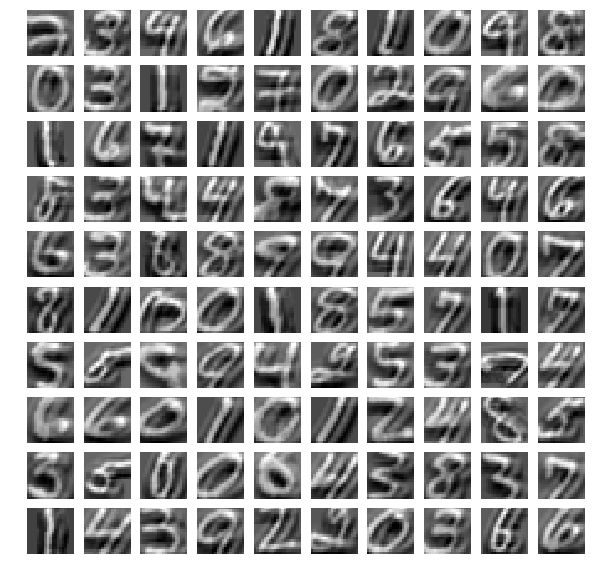

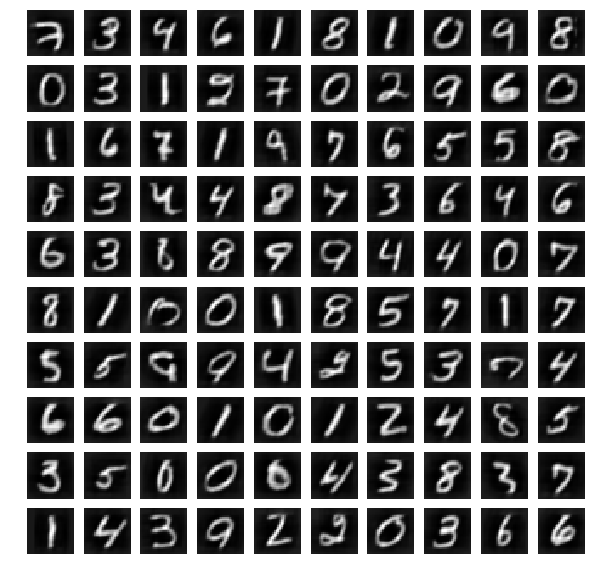

In [183]:
# Normalize and view the first layer
after_layer1 = (after_layer1-after_layer1.min((1,2),keepdims=True))/(after_layer1.max((1,2),keepdims=True)-after_layer1.min((1,2),keepdims=True))
after_layer1_inv = (after_layer1_inv-after_layer1_inv.min((1,2),keepdims=True))/(after_layer1_inv.max((1,2),keepdims=True)-after_layer1_inv.min((1,2),keepdims=True))
# view_images( weight_layer1.T.reshape((400,28,28)))
view_images(    after_layer1.reshape((100,19,19)))
view_images(after_layer1_inv.reshape((100,28,28)))

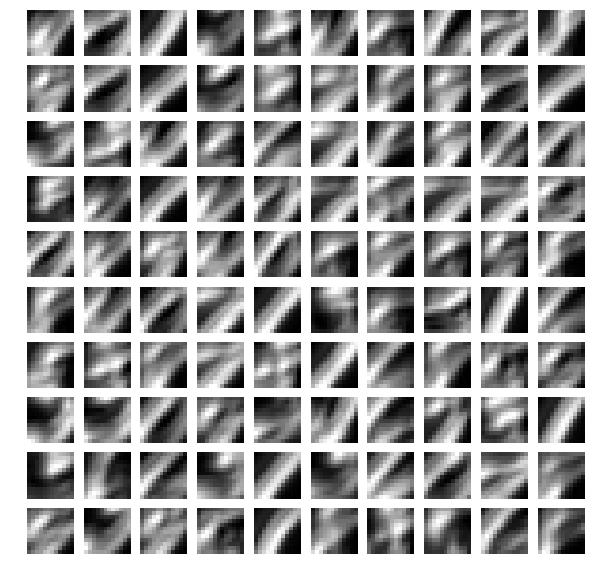

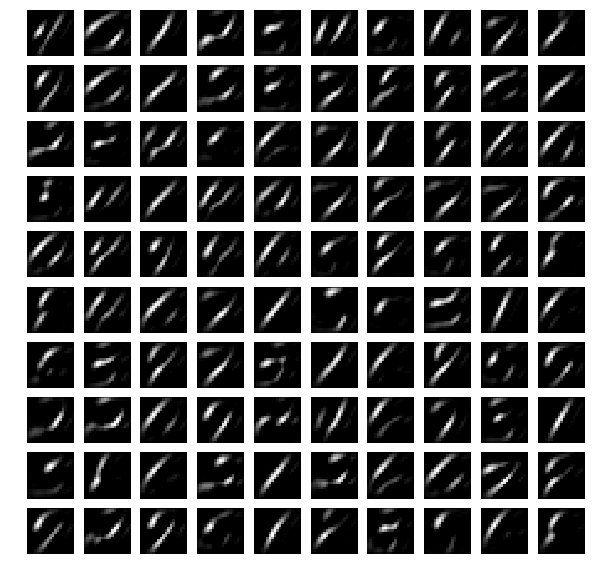

In [184]:
# Normalize and view the second layer
after_layer2 = (after_layer2-after_layer2.min((1,2),keepdims=True))/(after_layer2.max((1,2),keepdims=True)-after_layer2.min((1,2),keepdims=True))
after_layer2_inv = (after_layer2_inv-after_layer2_inv.min((1,2),keepdims=True))/(after_layer2_inv.max((1,2),keepdims=True)-after_layer2_inv.min((1,2),keepdims=True))
# view_images( weight_layer1.T.reshape((400,28,28)))
view_images(    after_layer2.reshape((100,12,12)))
view_images(after_layer2_inv.reshape((100,19,19)))

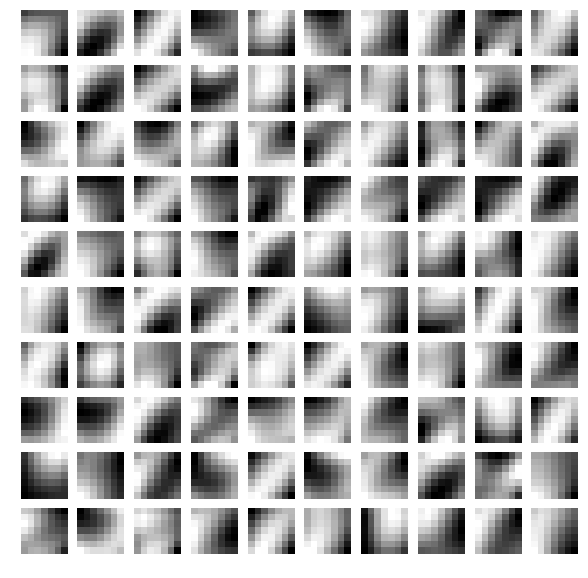

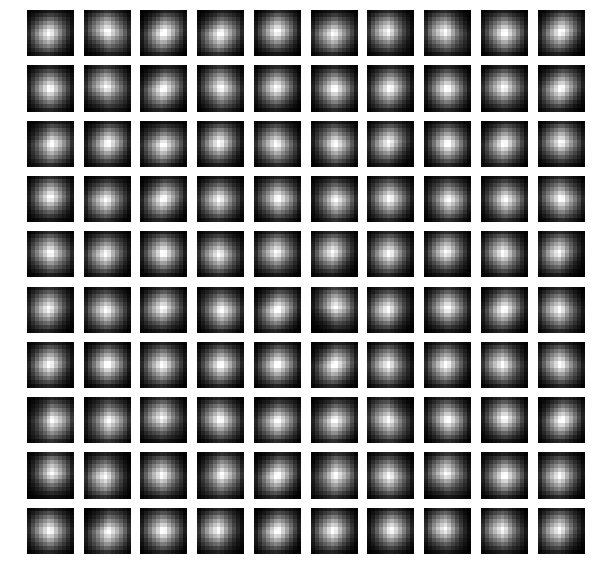

In [185]:
# Normalize and view the thrid layer
after_layer3 = (after_layer3-after_layer3.min((1,2),keepdims=True))/(after_layer3.max((1,2),keepdims=True)-after_layer3.min((1,2),keepdims=True))
after_layer3_inv = (after_layer3_inv-after_layer3_inv.min((1,2),keepdims=True))/(after_layer3_inv.max((1,2),keepdims=True)-after_layer3_inv.min((1,2),keepdims=True))
# view_images( weight_layer1.T.reshape((400,28,28)))
view_images(    after_layer3.reshape((100,7,7)))
view_images(after_layer3_inv.reshape((100,12,12)))

(3, 3, 64, 128)
(14, 14, 32)


IndexError: index 32 is out of bounds for axis 2 with size 32

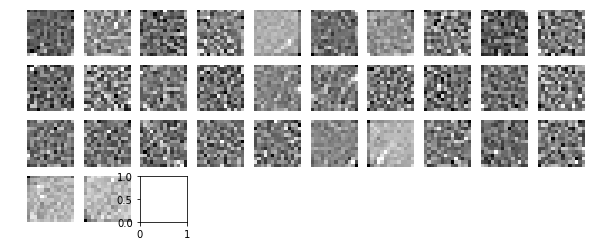

In [62]:
print(weight_layer3.shape)
temp = np.squeeze(weight_layer1[:,:,:,:])
print(temp.shape)

fig=plt.figure(figsize=(10, 10))
columns = 10;    rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(temp[:,:,i-1],cmap='gray')
    plt.grid(False)
    plt.axis('off')
plt.show()

# Reference
1. [duplicate], H. (2018). How to display multiple images in one figure correctly?. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
2. [duplicate], H. (2018). How to display multiple images in one figure correctly?. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
3. Tensorflow, a. (2018). additive Gaussian noise in Tensorflow. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/41174769/additive-gaussian-noise-in-tensorflow
4. right?, D. (2018). Derivative of Binary Cross Entropy - why are my signs not right?. Mathematics Stack Exchange. Retrieved 4 November 2018, from https://math.stackexchange.com/questions/2503428/derivative-of-binary-cross-entropy-why-are-my-signs-not-right
5. [duplicate], H. (2018). How to add noise (Gaussian/salt and pepper etc) to image in Python with OpenCV. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
6. numpy.random.randn — NumPy v1.15 Manual. (2018). Docs.scipy.org. Retrieved 4 November 2018, from https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html
7. tf.nn.conv2d_transpose  |  TensorFlow. (2018). TensorFlow. Retrieved 4 November 2018, from https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose
8. tf.Variable?, W. (2018). What's the difference between tf.placeholder and tf.Variable?. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/36693740/whats-the-difference-between-tf-placeholder-and-tf-variable
9. tensorflow, S. (2018). Swap tensor axes in tensorflow. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/38212205/swap-tensor-axes-in-tensorflow
10. Tensorflow, S. (2018). Shape of placeholder in Tensorflow. Stack Overflow. Retrieved 4 November 2018, from https://stackoverflow.com/questions/42606722/shape-of-placeholder-in-tensorflow
11. tf.nn.sigmoid_cross_entropy_with_logits | TensorFlow. (2018). TensorFlow. Retrieved 4 November 2018, from https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits